In [1]:
import os
import pandas as pd
import numpy as np

# Visualisation
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
%matplotlib inline
import seaborn as sns

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GroupKFold
from sklearn.metrics import make_scorer
from detect_peaks import detect_peaks


In [2]:
## consts :

SAMPLE_FREQ = 50 
FILE_MARGINES = 5* SAMPLE_FREQ  ## number of samples to ignore in the  start and in the end of the file (5 seconds )  
WINDOW_SIZE = 128  ## sliding window size 
PEAKS_WINDOW_SIZE = 5*WINDOW_SIZE  ## sliding window size for peaks count feature

DEVICE_MODE_LABELS = ['pocket','swing','texting','talking','whatever'] 
USER_MODE_LABELS = ['walking','fastwalking','stairs','static','whatever'] 

FEATURES = ['agforce','agyro',               ## avarage 
            'mgforce','mgyro',               ## median
            'vgforce','vgyro',               ## variance  
            'maxgforce','maxgyro',           ## max  
            'maxgforceabs','maxgyroabs',     ## abs max 
            'mingforce','mingyro',           ## min 
            'mingforceabs','mingyroabs',     ## abs min
            'ampgforce','ampgyro' ,          ## amplitude |max - min|
            'peaksgforce','peaksgyro',       ## peaks count in PEAKS_WINDOW_SIZE
            'light'                          ## embient light sensor  
           ]


### Calulates high level features and add to given data frame add norm feature for g-force , gyro vectors calculates additional statistics features  on the norm properties using sliding window fill NaN values 

In [3]:
    ## peaks detection :
    mph = 0 ## minimum peak height 
    mpd = 5 ## minimum peak distance = 20
    def peaks(values):
        return len(detect_peaks(values, mph, mpd, show=False))


In [4]:
def addFeatures(df):
    
    ## norm calculations :
    df['gforce'] = np.sqrt(df['gfx']**2 + df['gFy']**2 + df['gFz']**2) 
    df['gyro'] = np.sqrt(df['wx']**2 + df['wy']**2 + df['wz']**2)     
    
    ## calculates statistics features on rolling window :
    
    df['agforce'] = df['gforce'].rolling(window=WINDOW_SIZE,min_periods=1,center=False).mean()
    df['agyro']   = df['gyro'].rolling(window=WINDOW_SIZE,min_periods=1 ,center=False).mean()

    df['mgforce'] = df['gforce'].rolling(window=WINDOW_SIZE,min_periods=1,center=False).median()
    df['mgyro']   = df['gyro'].rolling(window=WINDOW_SIZE,min_periods=1 ,center=False).median()

    df['vgforce'] = df['gforce'].rolling(window=WINDOW_SIZE,min_periods=1,center=False).var()
    df['vgyro']   = df['gyro'].rolling(window=WINDOW_SIZE,min_periods=1,center=False).var()

    df['maxgforce'] = df['gforce'].rolling(window=WINDOW_SIZE,min_periods=1,center=False).max()
    df['maxgyro']   = df['gyro'].rolling(window=WINDOW_SIZE,min_periods=1 ,center=False).max()

    df['maxgforceabs'] = abs(df['maxgforce'])
    df['maxgyroabs']   = abs(df['maxgyro']) 

    df['mingforce'] = df['gforce'].rolling(window=WINDOW_SIZE,min_periods=1,center=False).min()
    df['mingyro']  = df['gyro'].rolling(window=WINDOW_SIZE,min_periods=1 ,center=False).min()

    df['mingforceabs'] = abs(df['mingforce'])
    df['mingyroabs']   = abs(df['mingyro']) 
    
    df['ampgforce'] = df['maxgforce'] - df['mingforce']
    df['ampgyro']  = df['maxgyro'] - df['mingyro']
    
    df['light'] = df['I'] if 'I' in df else 0.0 

    df['peaksgforce'] = df['gforce'].rolling(window=PEAKS_WINDOW_SIZE,min_periods=1 ,center=False).apply(peaks)
    df['peaksgyro'] = df['gyro'].rolling(window=PEAKS_WINDOW_SIZE,min_periods=1 ,center=False).apply(peaks)    

### Read csv data file , add label colomn by parsing the file name  add high level features , crop file edges  Todo : normlize , remove dc 

In [5]:
def loadFile(root,file):
    data=pd.read_csv(os.path.join(root,file))
    if len(data) < 1000 :
        print (' only ' , len(data) , ' samples in file ', file , ' pass ')
        return pd.DataFrame()
    
    print('loading : ' , file) 

    print('loading : ' , len(data) , ' samples from ', file) 
    
    ## usefull property : 
    data['source']=file  

    ## default label values in case file name not contains label  
    data['devicemodeDescription']=DEVICE_MODE_LABELS[-1] ## 'whatever' label 
    data['devicemode'] = len(DEVICE_MODE_LABELS)

    ## search device mode label in file name and add as new properties :
    for label in DEVICE_MODE_LABELS:
        if label.lower() in file.lower():  
            data['devicemodeDescription']=label         ## label name 
            data['devicemode'] = DEVICE_MODE_LABELS.index(label)    ## label index 
            break
    
    ## add high level features 
    addFeatures(data)
        
    ## crop samples from start and from the end of the file :
    margin = min(len(data) / 2 - 1 , FILE_MARGINES)
    data.drop(data.index[range(0,margin)],axis=0,inplace=True)
    data.drop(data.index[range(-margin,-1)],axis=0,inplace=True)   
    ##  print(len(data) , ' samples after cropping ' , margin , 'samples from start-end of the file  ')
    return data 

In [6]:
def loadFiles(inputDir):
    print ('loading files from : ' , inputDir )
    return pd.concat([loadFile(inputDir,f) for f in os.listdir(inputDir) if f.lower().endswith('.csv')])  

In [7]:
rdf = loadFiles(r'../all-data/utf8')
print('=========================================================')
print( 'total train samples ' , len(rdf) , ' from ' ,len(rdf.source.unique()),  ' files ')

('loading files from : ', '../all-data/utf8')
('loading : ', 'RightPocket.csv')
('loading : ', 7486, ' samples from ', 'RightPocket.csv')
('loading : ', 'TalkingLeftHandFromSignBack.csv')
('loading : ', 3223, ' samples from ', 'TalkingLeftHandFromSignBack.csv')
('loading : ', 'TalkingLeftHandToSignChexk.csv')
('loading : ', 3366, ' samples from ', 'TalkingLeftHandToSignChexk.csv')
('loading : ', 'TextingLeftHand5.csv')
('loading : ', 7101, ' samples from ', 'TextingLeftHand5.csv')
('loading : ', 'LeftHandTextingMore.csv')
('loading : ', 3914, ' samples from ', 'LeftHandTextingMore.csv')
('loading : ', 'SwingLeftHandToSign.csv')
('loading : ', 3356, ' samples from ', 'SwingLeftHandToSign.csv')
('loading : ', 'SwingRightPhoneDownScBody.csv')
('loading : ', 9258, ' samples from ', 'SwingRightPhoneDownScBody.csv')
('loading : ', 'ariella_lg3_swing_2017-09-1215.45.47.csv')
('loading : ', 5369, ' samples from ', 'ariella_lg3_swing_2017-09-1215.45.47.csv')
('loading : ', 'PocketLeftStairsUp2.

In [8]:
rdf.groupby('devicemodeDescription').devicemode.count()

devicemodeDescription
pocket      36645
swing       80263
talking      5591
texting     48053
whatever     6089
Name: devicemode, dtype: int64

In [9]:
rdf.groupby('source').devicemode.count()

source
LeftHandTextingMore.csv                              3415
LeftPocketJeansNormalWalk.csv                        6074
LeftPocketStatic.csv                                 2204
PocketLeftJeansNormlWalk.csv                         6325
PocketLeftNormalWalking.csv                          6025
PocketLeftSideToSign.csv                             2788
PocketLeftStairsDown1.csv                             635
PocketLeftStairsDown2.csv                            1222
PocketLeftStairsDown3.csv                             723
PocketLeftStairsUp1.csv                               778
PocketLeftStairsUp2.csv                              1564
PocketLeftStairsUp3.csv                               720
RightPocket.csv                                      6987
StaticSittingRightHandHoldingLightOn.csv             2924
SwingLeftHand.csv                                    2796
SwingLeftHandFromSignBack.csv                        2809
SwingLeftHandToSign.csv                              2857
SwingLe

In [10]:
rdf.head()

,Bx,By,Bz,I,Latitude,Longitude,Speed (m/s),Unnamed: 11,Unnamed: 12,Unnamed: 15,...,p,peaksgforce,peaksgyro,source,time,vgforce,vgyro,wx,wy,wz
250,-23.7823,31.0425,31.3141,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,979.8540,18.0,20.0,RightPocket.csv,9.784,0.134628,1.310145,2.0873,-1.7908,0.2970
251,-23.7823,31.0425,31.3141,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,979.8540,18.0,20.0,RightPocket.csv,9.845,0.132554,1.306404,2.0873,-1.7908,0.2970
252,-23.7823,31.0425,31.3141,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,979.8540,18.0,20.0,RightPocket.csv,9.848,0.130472,1.305345,1.1153,-0.0765,1.5819
253,-31.2820,28.7933,26.3641,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,979.8540,18.0,20.0,RightPocket.csv,9.924,0.130786,1.304284,1.1153,-0.0765,1.5819
254,-31.2820,28.7933,26.3641,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,979.8147,18.0,20.0,RightPocket.csv,9.935,0.131029,1.295209,1.1153,-0.0765,1.5819


#### visualize features 

LeftHandTextingMore.csv


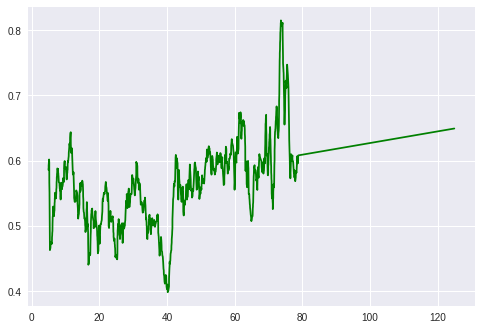

LeftPocketJeansNormalWalk.csv


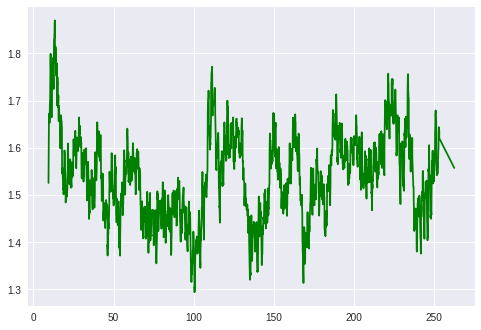

LeftPocketStatic.csv


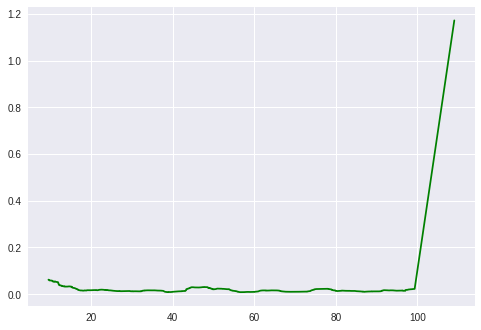

PocketLeftJeansNormlWalk.csv


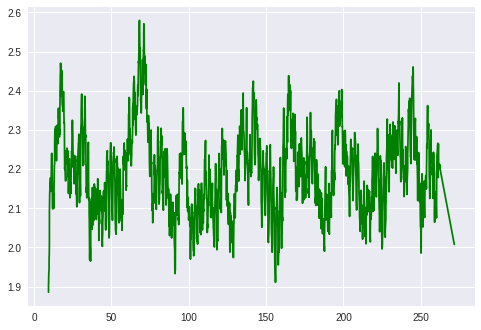

PocketLeftNormalWalking.csv


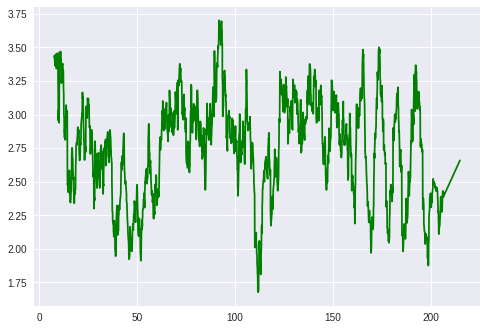

PocketLeftSideToSign.csv


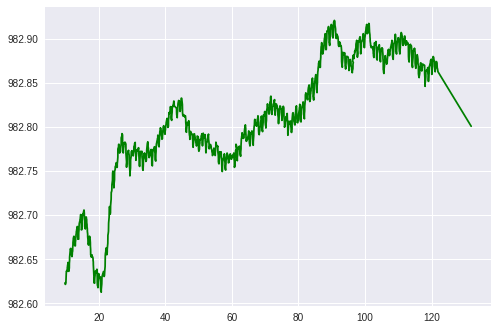

PocketLeftStairsDown1.csv


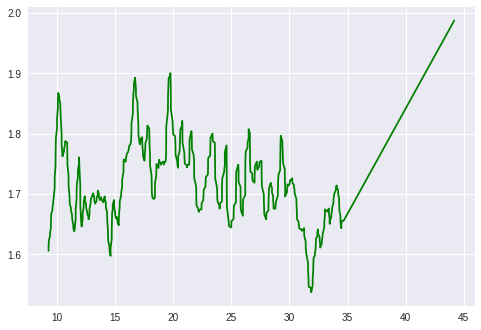

PocketLeftStairsDown2.csv


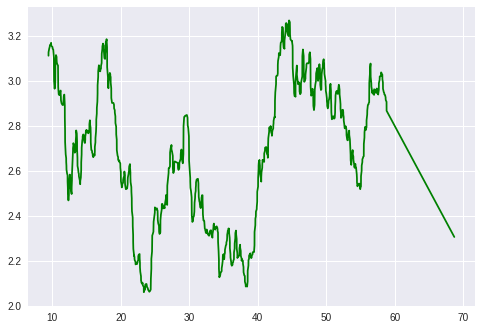

PocketLeftStairsDown3.csv


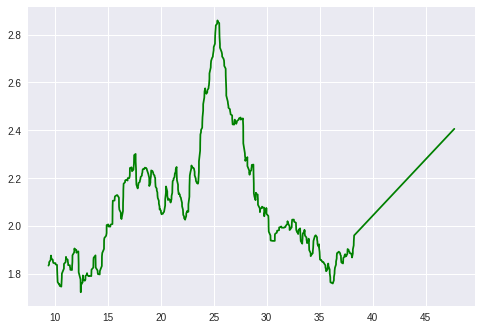

PocketLeftStairsUp1.csv


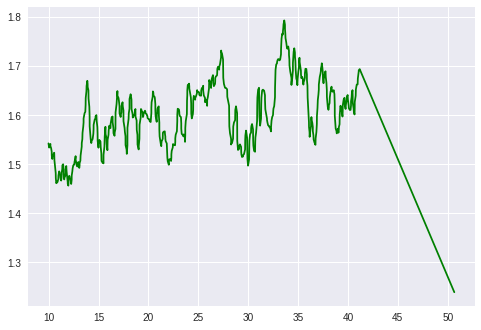

PocketLeftStairsUp2.csv


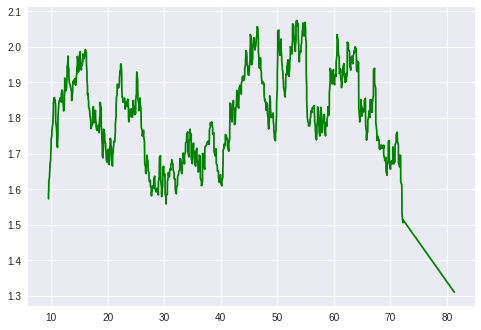

PocketLeftStairsUp3.csv


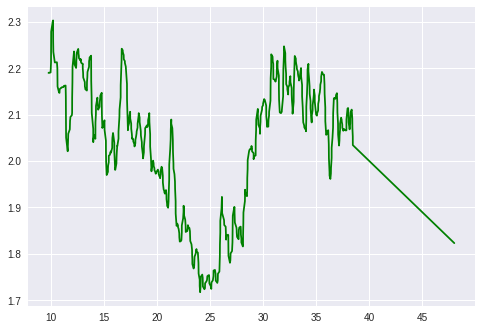

RightPocket.csv


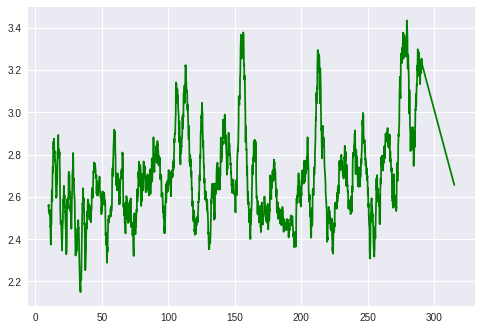

StaticSittingRightHandHoldingLightOn.csv


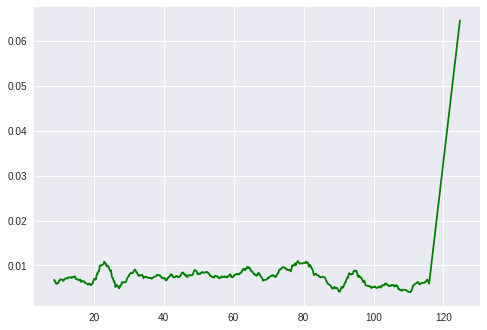

SwingLeftHand.csv


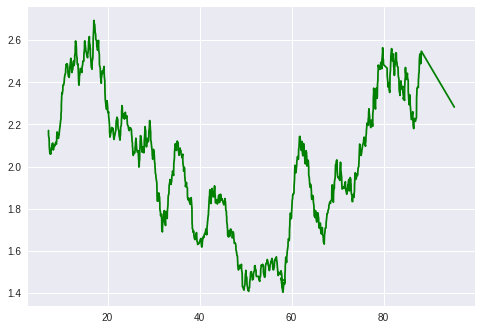

SwingLeftHandFromSignBack.csv


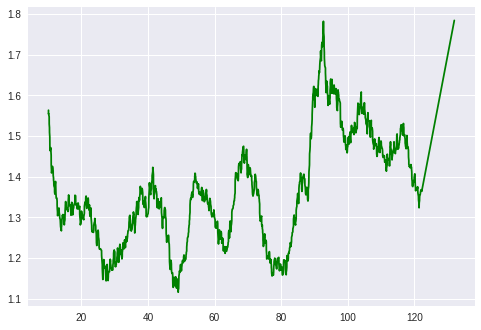

SwingLeftHandToSign.csv


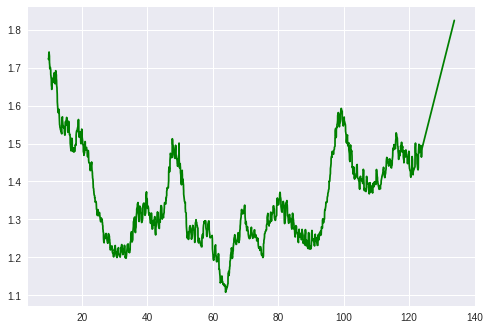

SwingLeftNormal.csv


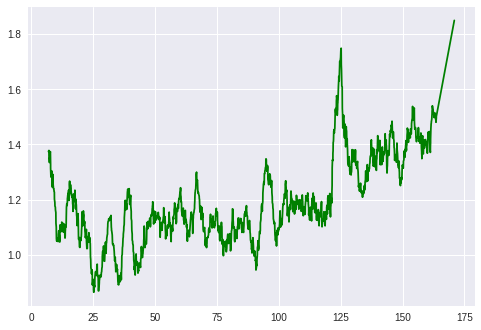

SwingRight2.csv


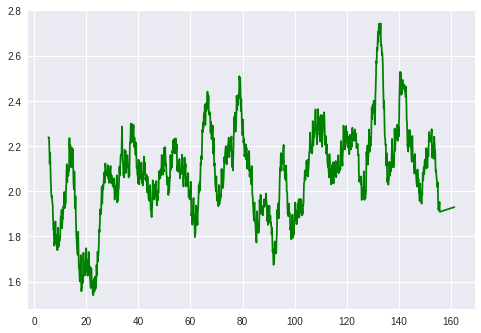

SwingRightPhoneDown.csv


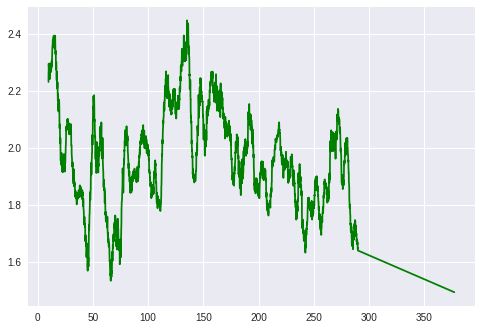

SwingRightPhoneDownScBody.csv


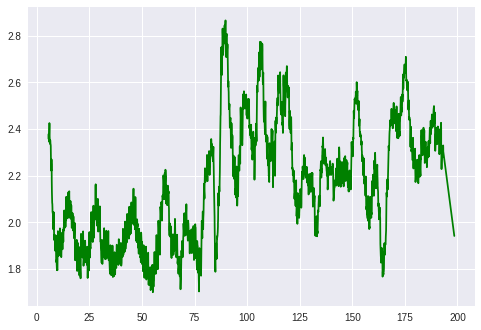

TalkingLeftHandFromSignBack.csv


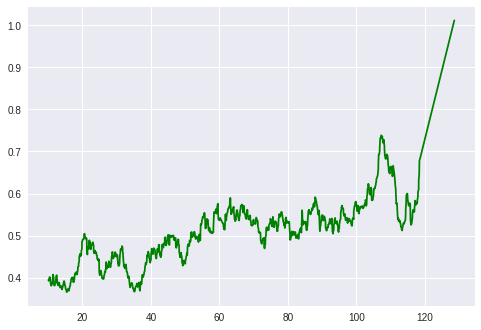

TalkingLeftHandToSignChexk.csv


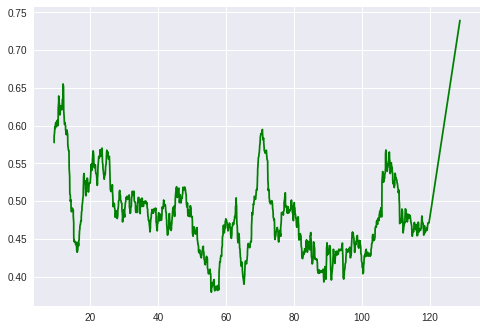

TexringLeftHandUntilSign1.csv


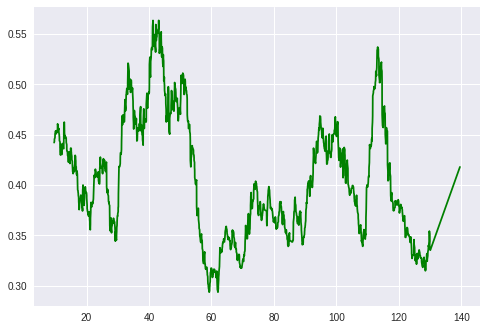

TextingLeftHand5.csv


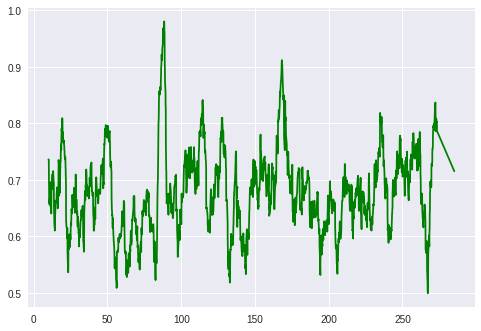

TextingLeftHandMore2.csv


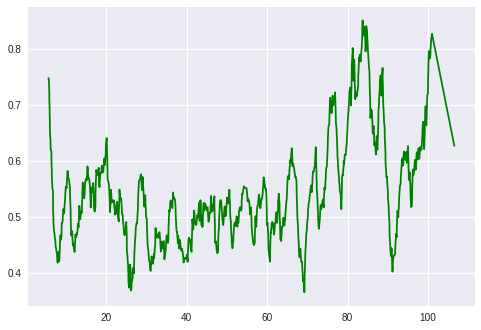

TextingLeftHandSignBack.csv


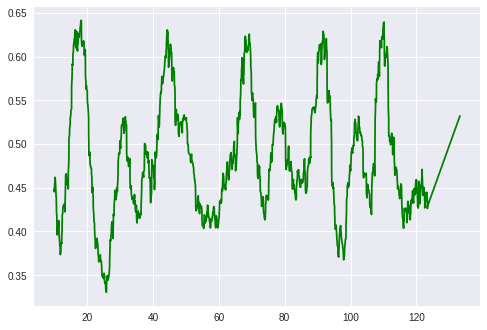

TextingPointingDorwatd.csv


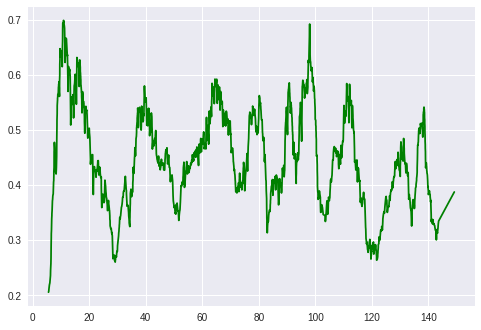

TextingRight.csv


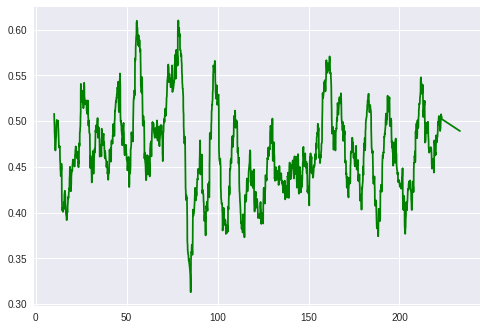

alon-lg2-texting-walking-2017-09-1016.39.42.csv


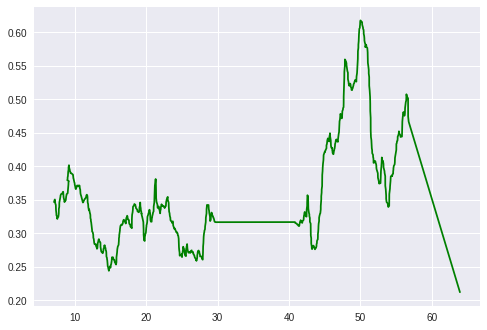

ariella_lg3_swing_2017-09-1215.45.47.csv


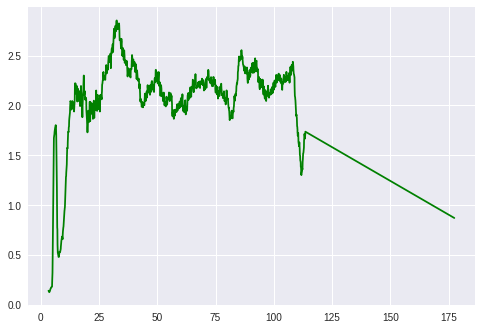

ariella_lg3_texting_2017-09-1215.42.51.csv


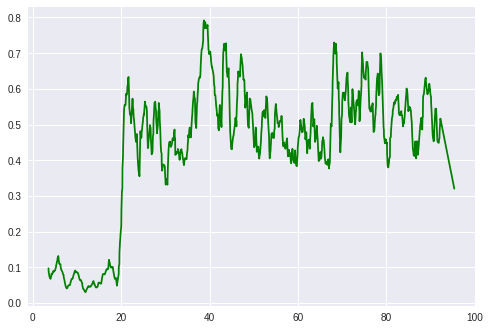

boris-lg3-texting-walking-2017-09-1108.17.25.csv


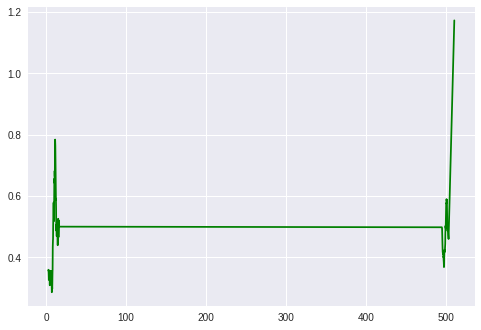

swing2.csv


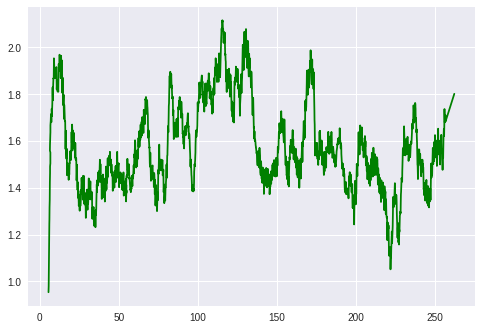

swing4.csv


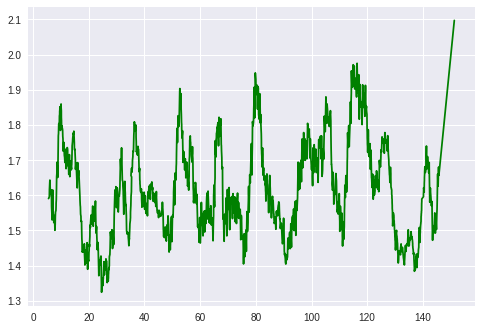

swingLeftHandPhoneDownScBody.csv


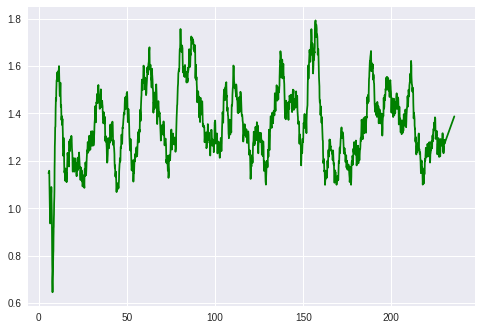

texting_stairs_down_2017-09-0511.05.24.csv


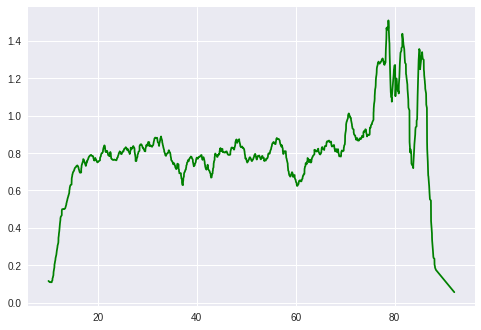

texting_stairs_up_2017-09-0511.01.44.csv


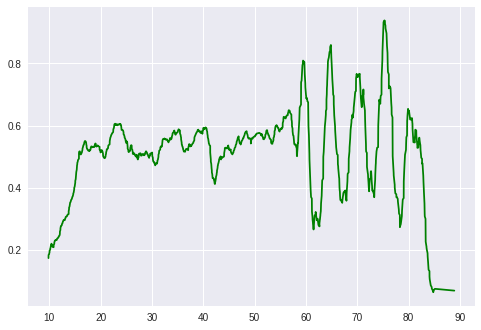

yuval-htc-pocket_walking-2017-09-0408.58.13.csv


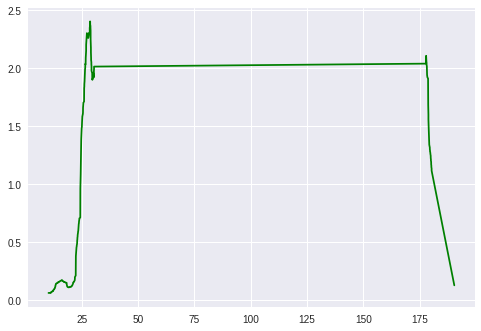

yuval-htc-swing_walking-2017-09-0316.04.51.csv


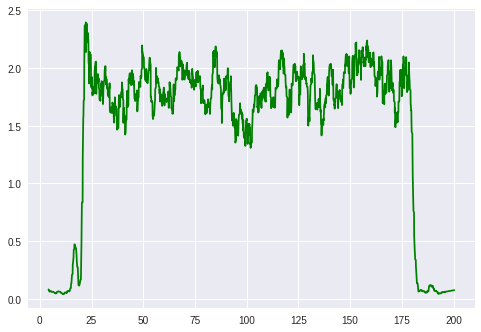

yuval-htc-texting-walking-2017-09-0315.53.12.csv


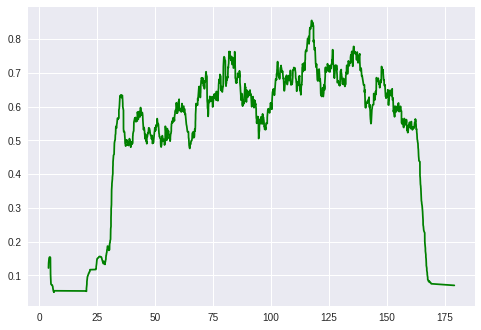

In [11]:
for s in rdf.groupby('source').source:
    print (s[0])
    yy = rdf[rdf.source == s[0]]
    plt.plot(yy.time,yy.agyro, 'g' ) 
    plt.show()


## cross_validation (  group by source proprty ) 
K-fold iterator variant with non-overlapping groups.
The same group will not appear in two different folds
The number of distinct groups has to be at least equal to the number of folds.
The folds are approximately balanced in the sense that the number of distinct groups is approximately the same in each fold.

In [12]:
# take only relevants features :
df = rdf[FEATURES]
df.head()

,agforce,agyro,mgforce,mgyro,vgforce,vgyro,maxgforce,maxgyro,maxgforceabs,maxgyroabs,mingforce,mingyro,mingforceabs,mingyroabs,ampgforce,ampgyro,peaksgforce,peaksgyro,light
250,1.103264,2.553854,1.059943,2.75977,0.134628,1.310145,1.824619,4.496694,1.824619,4.496694,0.449018,0.811402,0.449018,0.811402,1.375601,3.685292,18.0,20.0,0.0
251,1.105201,2.561111,1.059943,2.75977,0.132554,1.306404,1.824619,4.496694,1.824619,4.496694,0.449018,0.811402,0.449018,0.811402,1.375601,3.685292,18.0,20.0,0.0
252,1.107138,2.561891,1.059943,2.75977,0.130472,1.305345,1.824619,4.496694,1.824619,4.496694,0.533182,0.811402,0.533182,0.811402,1.291437,3.685292,18.0,20.0,0.0
253,1.101184,2.562670,1.001563,2.75977,0.130786,1.304284,1.824619,4.496694,1.824619,4.496694,0.533182,0.811402,0.533182,0.811402,1.291437,3.685292,18.0,20.0,0.0
254,1.095230,2.548161,0.943184,2.75977,0.131029,1.295209,1.824619,4.496694,1.824619,4.496694,0.533182,0.811402,0.533182,0.811402,1.291437,3.685292,18.0,20.0,0.0


In [13]:
k= 4 ##len(rdf.source.unique()) 
x_train= df
y_train = rdf.devicemode
forest = RandomForestClassifier()
tree = DecisionTreeClassifier()
knn5 = KNeighborsClassifier(n_neighbors=5)
lin_svm = svm.LinearSVC() ## (C=1.0, class_weight=None, dual=True, fit_intercept=True,
                         ## intercept_scaling=1, loss='squared_hinge', max_iter=1000,
                         ## multi_class='ovr', penalty='l2', random_state=None, tol=0.0001, verbose=0)

In [14]:
def sourceFold(): 
    print ('list of source files for each kfold : ' )    
    _kfold = GroupKFold(n_splits=k) 
    _itr = _kfold.split(x_train, y_train, groups=rdf.source)  
    c = 0 
    sf = {}
    for i in _itr:
        ## print (c , str(rdf.iloc[i[1]].source.unique()))
        sf[c]= str(rdf.iloc[i[1]].source.unique())
        c = c+1
    return sf 

In [15]:
def CalcKFoldAccuracy(classifier,X,Y, scoring,k):
    group_kfold = GroupKFold(n_splits=k)     
    groups_itr = group_kfold.split(x_train, y_train, groups=rdf.source)    
    return cross_val_score(classifier, X, Y, cv=groups_itr, scoring=scoring)

In [ ]:
scoring='accuracy' 
sf = sourceFold()
fa = CalcKFoldAccuracy(knn5,x_train,y_train,scoring,k)
for i in range(k):
    plt.title(str(fa[i]) + '  ' + sf[i][2:-2])
    tt = rdf[rdf.source == sf[i][2:-2]]
    plt.plot(tt.time,tt.agyro,'g') 
    plt.show() 

list of source files for each kfold : 


In [ ]:
scoring='accuracy' 
print ('KNN : ')
print (CalcKFoldAccuracy(knn5,x_train,y_train,scoring,k))
print ('RF : ')
print (CalcKFoldAccuracy(forest,x_train,y_train, scoring,k))
print ('SVM : ')
print (CalcKFoldAccuracy(lin_svm,x_train,y_train, scoring,k))

KNN : 
[ 0.95176678  0.          0.96874073  0.99155155  0.9107424   0.85035095
  0.08142169  0.94532704  0.99985174  0.96706444  0.89117409  0.0095489
  0.98788382  0.20204651  0.05555556  1.          0.98037004  0.01149713
  0.88591138  0.        ]
RF : 


#### Feature importance 

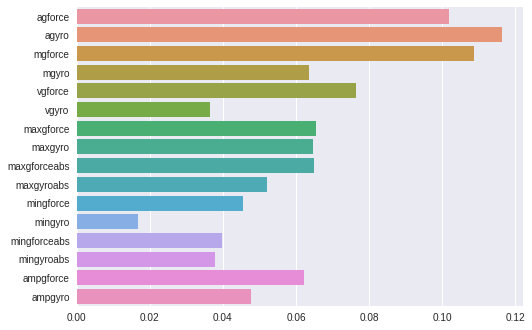

In [36]:
forest.fit(x_train,y_train)
sns.barplot(y=x_train.columns,x=forest.feature_importances_,orient="h" )

### visualize

In [24]:
cor_mat = rdf[FEATURES + ['devicemode']] .corr()
cor_mat

,agforce,agyro,mgforce,mgyro,vgforce,vgyro,maxgforce,maxgyro,mingforce,minxgyro,ampgforce,ampxgyro,devicemode
agforce,1.000000,0.696062,0.820978,0.764672,0.499679,0.246872,0.537963,0.439780,0.117562,0.515889,0.416149,0.160473,-0.260831
agyro,0.696062,1.000000,0.537844,0.966930,0.491066,0.680385,0.489151,0.877253,-0.196795,0.725319,0.464919,0.558558,-0.599857
mgforce,0.820978,0.537844,1.000000,0.612023,0.248036,0.162738,0.205913,0.320771,0.105244,0.366937,0.142122,0.100235,-0.048216
mgyro,0.764672,0.966930,0.612023,1.000000,0.467247,0.543378,0.477024,0.767388,-0.126802,0.693260,0.434839,0.434854,-0.528336
vgforce,0.499679,0.491066,0.248036,0.467247,1.000000,0.275201,0.873485,0.381973,-0.583507,0.460764,0.896341,0.207177,-0.371557
vgyro,0.246872,0.680385,0.162738,0.543378,0.275201,1.000000,0.232096,0.900254,-0.215152,0.318886,0.255296,0.779359,-0.483653
maxgforce,0.537963,0.489151,0.205913,0.477024,0.873485,0.232096,1.000000,0.350825,-0.462329,0.479277,0.967559,0.166383,-0.465318
maxgyro,0.439780,0.877253,0.320771,0.767388,0.381973,0.900254,0.350825,1.000000,-0.245813,0.549110,0.363268,0.775880,-0.595594
mingforce,0.117562,-0.196795,0.105244,-0.126802,-0.583507,-0.215152,-0.462329,-0.245813,1.000000,-0.235746,-0.671354,-0.203586,0.242336
minxgyro,0.515889,0.725319,0.366937,0.693260,0.460764,0.318886,0.479277,0.549110,-0.235746,1.000000,0.467764,0.279480,-0.439512


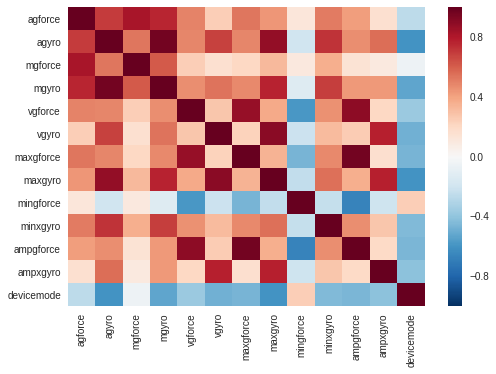

In [25]:
sns.heatmap(cor_mat)

## split train & test data

In [26]:
x_train, x_test, y_train, y_test = train_test_split(df, rdf.devicemode, test_size=0.4, random_state=42,stratify=rdf.devicemode)

[[23886   133    24]
 [  117 39528    81]
 [   23    80 20402]]


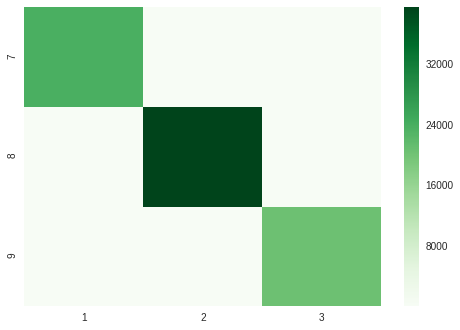

In [27]:
knn5 = KNeighborsClassifier(n_neighbors=5)
knn5.fit(x_train,y_train)
knn5_pred = knn5.predict(x_test)
print(confusion_matrix(y_pred=knn5_pred,y_true=y_test))
sns.heatmap(xticklabels=range(1,10),yticklabels=range(1,10),data = confusion_matrix(y_pred=knn5_pred,y_true=y_test),cmap='Greens')

In [28]:
print('classification report results:\r\n' + classification_report(y_pred=knn5_pred,y_true=y_test))

classification report results:
             precision    recall  f1-score   support

          0       0.99      0.99      0.99     24043
          1       0.99      1.00      0.99     39726
          2       0.99      0.99      0.99     20505

avg / total       0.99      0.99      0.99     84274



In [29]:
accuracy_score(y_test,knn5_pred)

0.99456534637017346

### validate on file outside of the train bucket 

In [30]:
rvl = loadFiles(r'../raw-data/validation/utf8')
print ('=========================================================')
print ('total validation samples ' , len(rvl) )

('loading files from : ', '../raw-data/validation/utf8')
('loading : ', 'swing3.csv')
('loading : ', 'Pocket2.csv')
('loading : ', 'Texting2.csv')
('total validation samples ', 15752)


In [31]:
rvl.dropna(axis=1,inplace=True)
rvl.drop("source",axis=1).head()

,time,gfx,gFy,gFz,wx,wy,wz,p,Bx,By,...,mgyro,vgforce,vgyro,maxgforce,maxgyro,mingforce,minxgyro,ampgforce,ampxgyro,light
250,5.575,-0.7754,-0.6393,-0.0722,0.0342,-0.0166,-0.1185,978.6745,4.1412,43.5471,...,0.305435,0.039810,0.967789,1.565355,2.748156,0.354204,0.044538,1.211151,2.623707,0.0
251,5.576,-0.8192,-0.6118,-0.1383,0.0342,-0.0166,-0.1185,978.6745,4.1412,43.5471,...,0.305435,0.039242,0.966377,1.565355,2.748156,0.354204,0.044538,1.211151,2.623707,0.0
252,5.616,-0.8192,-0.6118,-0.1383,-0.2990,-0.3050,-0.1474,978.6745,4.1412,43.5471,...,0.305435,0.038664,0.962026,1.565355,2.748156,0.354204,0.044538,1.211151,2.296323,0.0
253,5.617,-0.8192,-0.6118,-0.1383,-0.2990,-0.3050,-0.1474,978.6745,4.1412,43.5471,...,0.305435,0.037927,0.957503,1.565355,2.748156,0.354204,0.044538,1.211151,2.296323,0.0
254,5.638,-0.7282,-0.6251,-0.0240,-0.2990,-0.3050,-0.1474,978.6745,4.1412,43.5471,...,0.305435,0.037203,0.952807,1.565355,2.748156,0.354204,0.044538,1.211151,2.296323,0.0


In [32]:
vl = rvl[FEATURES]
vl.head()

,agforce,agyro,mgforce,mgyro,vgforce,vgyro,maxgforce,maxgyro,mingforce,minxgyro,ampgforce,ampxgyro
250,1.009667,0.826034,0.998835,0.305435,0.039810,0.967789,1.565355,2.748156,0.354204,0.044538,1.211151,2.623707
251,1.011935,0.814236,0.999904,0.305435,0.039242,0.966377,1.565355,2.748156,0.354204,0.044538,1.211151,2.623707
252,1.014203,0.804996,1.000973,0.305435,0.038664,0.962026,1.565355,2.748156,0.354204,0.044538,1.211151,2.296323
253,1.016724,0.795755,1.000973,0.305435,0.037927,0.957503,1.565355,2.748156,0.354204,0.044538,1.211151,2.296323
254,1.018685,0.786515,1.000973,0.305435,0.037203,0.952807,1.565355,2.748156,0.354204,0.044538,1.211151,2.296323


In [34]:
print ('KNN : ')
knn5.fit(x_train,y_train)
knn5_val = knn5.predict(vl)
print(confusion_matrix(y_pred=knn5_val,y_true=rvl.devicemode))
##sns.heatmap(xticklabels=range(1,10),yticklabels=range(1,10),data = confusion_matrix(y_pred=knn5_val,y_true=rvl.devicemode),cmap='Greens')
print(classification_report(y_pred=knn5_val,y_true=rvl.devicemode))
accuracy_score(rvl.devicemode,knn5_val)
print ( '=========================================================')

print ('RF : ')
forest.fit(x_train,y_train)
forest_val = forest.predict(vl)
print(confusion_matrix(y_pred=forest_val,y_true=rvl.devicemode))
print(classification_report(y_pred=forest_val,y_true=rvl.devicemode))
accuracy_score(rvl.devicemode,forest_val)
print( '=========================================================')

print ('SVM : ')
lin_svm.fit(x_train,y_train)
svm_val = lin_svm.predict(vl)
print(confusion_matrix(y_pred=svm_val,y_true=rvl.devicemode))
print(classification_report(y_pred=svm_val,y_true=rvl.devicemode))
accuracy_score(rvl.devicemode,svm_val)

KNN : 
[[6104 1435   12]
 [ 396 3980   56]
 [   0  567 3202]]
             precision    recall  f1-score   support

          0       0.94      0.81      0.87      7551
          1       0.67      0.90      0.76      4432
          2       0.98      0.85      0.91      3769

avg / total       0.87      0.84      0.85     15752

RF : 
[[3749 3800    2]
 [ 283 4098   51]
 [  29  732 3008]]
             precision    recall  f1-score   support

          0       0.92      0.50      0.65      7551
          1       0.47      0.92      0.63      4432
          2       0.98      0.80      0.88      3769

avg / total       0.81      0.69      0.70     15752

SVM : 
[[3535 3979   37]
 [ 220 4146   66]
 [   1    0 3768]]
             precision    recall  f1-score   support

          0       0.94      0.47      0.63      7551
          1       0.51      0.94      0.66      4432
          2       0.97      1.00      0.99      3769

avg / total       0.83      0.73      0.72     15752



0.72682833925850687

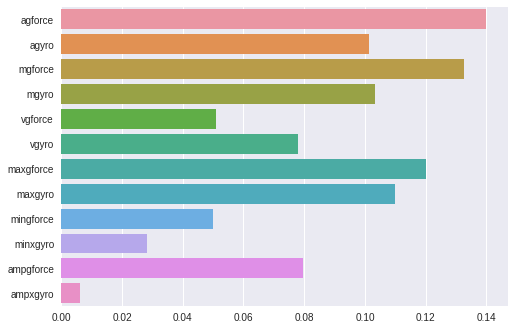

In [24]:
sns.barplot(y=vl.columns,x=forest.feature_importances_,orient="h" )

### Parameters tuning :

In [25]:
n_trees = range(10,200)
max_features = ['sqrt','log2']
cores =-1
param_dict = dict(n_estimators=n_trees, max_features=max_features)
grid = RandomizedSearchCV(forest, param_dict, cv=5, scoring='accuracy')

In [26]:
grid.fit(x_train,y_train)

KeyboardInterrupt: 

In [ ]:
print (grid.best_score_)
print (grid.best_params_)
print (grid.best_estimator_)

In [57]:
forset = RandomForestClassifier(n_estimators=grid.best_params_["n_estimators"],max_features =grid.best_params_["max_features"])
forest.fit(x_train, y_train)
forest_val = forest.predict(vl)
print(classification_report(y_pred=forest_val,y_true=rvl.devicemode))
print (accuracy_score(rvl.devicemode,forest_val))

             precision    recall  f1-score   support

          0       0.97      0.24      0.38      7551
          1       0.43      0.98      0.60      4432
          2       0.98      1.00      0.99      3769

avg / total       0.82      0.63      0.59     15752

0.630078720163


In [ ]:
print ('Thanks !')